<a href="https://colab.research.google.com/github/seungjun02/reinforcement-Learning/blob/main/chapter2/2_11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

nonstationary 한 경우에서 다양한 다중 선택 알고리즘에 대한 파라미터를 그래프로 나타내기


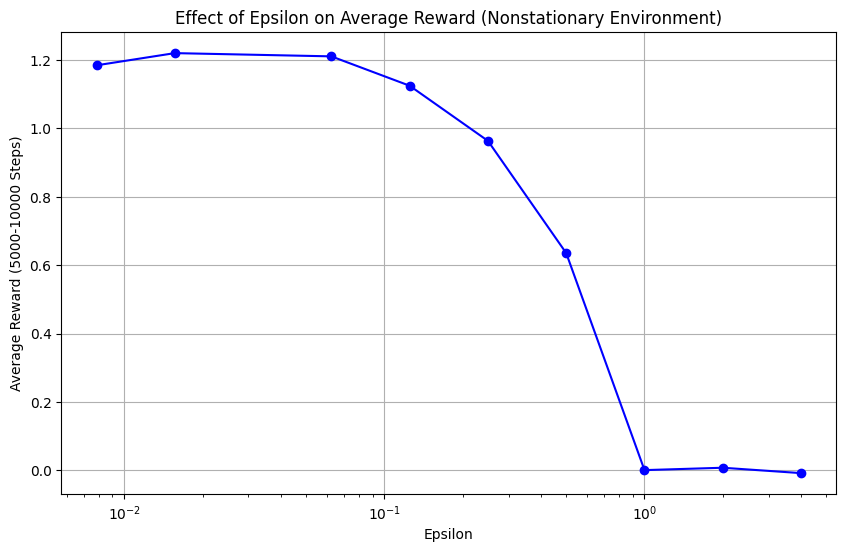

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 설정값
num_actions = 10  # 행동 개수
num_steps = 10000  # 시간 단계
num_experiments = 2000  # 반복 실험 횟수
epsilons = [1/128, 1/64, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]  # 입실론 값 리스트
alpha = 0.1  # 고정 학습률
eval_start = 5000  # 평균 보상 계산 시작 시점

# 평균 보상 저장 (각 입실론 별)
final_avg_rewards = []

# 2000번 실험 수행
for epsilon in epsilons:
    avg_rewards = np.zeros(num_steps)  # 각 단계별 평균 보상 기록

    for _ in range(num_experiments):
        # 환경 초기화
        q_values = np.zeros((num_steps, num_actions))  # 실제 Q 값
        q_values[0] = np.full(num_actions, 0.0)  # 초기값 0

        q_a = np.zeros(num_actions)  # Q 추정값 (고정 학습률)

        # 시뮬레이션 시작
        for t in range(1, num_steps):
            # Q 값 변화 (Nonstationary 환경)
            q_values[t] = q_values[t-1] + np.random.normal(0, 0.01, size=num_actions)

            # 입실론 탐욕적 행동 선택
            if np.random.rand() < epsilon:
                action = np.random.choice(num_actions)  # 무작위 행동
            else:
                action = np.argmax(q_a)  # 최적 행동

            # 보상 획득
            reward = np.random.normal(q_values[t, action], 1)  # 평균이 실제 Q 값인 정규분포

            # 고정 학습률 방식으로 Q 업데이트
            q_a[action] += alpha * (reward - q_a[action])

            # 평균 보상 기록 (각 단계에서 평균을 계산하기 위해 누적)
            avg_rewards[t] += reward

    # 평균 보상 계산 (2000번 실행 평균)
    avg_rewards /= num_experiments

    # 5000~10000 타임스텝 동안의 평균 보상 계산
    final_avg_reward = np.mean(avg_rewards[eval_start:])
    final_avg_rewards.append(final_avg_reward)

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(epsilons, final_avg_rewards, marker='o', linestyle='-', color='b')

plt.xscale("log")  # 입실론 값이 로그 스케일이므로 로그 스케일 적용
plt.xlabel("Epsilon")
plt.ylabel("Average Reward (5000-10000 Steps)")
plt.title("Effect of Epsilon on Average Reward (Nonstationary Environment)")
plt.grid(True)
plt.show()

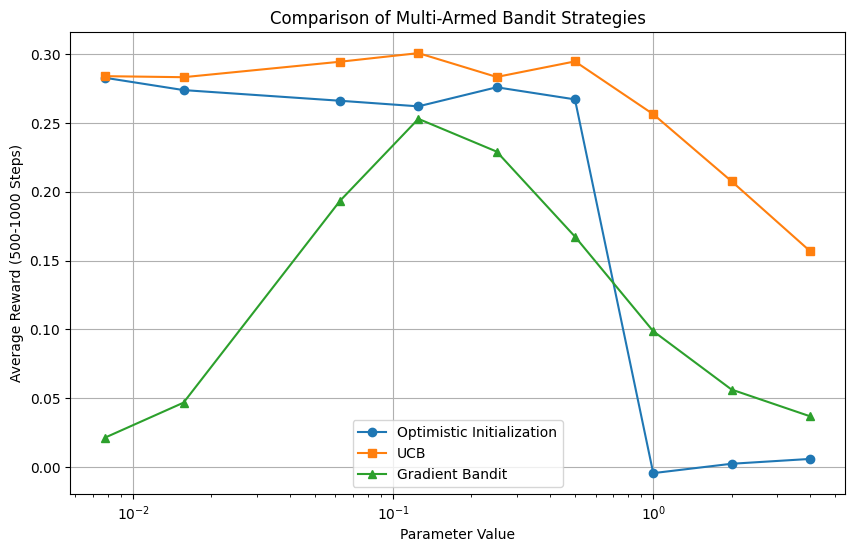

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 실험 설정
num_actions = 10  # 행동 개수
num_steps = 1000  # 시간 단계
num_experiments = 1000  # 반복 실험 횟수
param_values = [1/128, 1/64, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]  # 탐색할 파라미터 값
eval_start = 500  # 평균 보상 계산 시작 시점
alpha = 0.1  # 고정 학습률 (탐욕적 방법에서 사용)

# 각 방법별 평균 보상 저장
avg_rewards_optimistic = []
avg_rewards_ucb = []
avg_rewards_gradient = []

# 긍정적 초기화 탐욕적 방법
for q_init in param_values:
    avg_rewards = np.zeros(num_steps)

    for _ in range(num_experiments):
        q_values = np.zeros((num_steps, num_actions))
        q_values[0] = np.full(num_actions, 0.0)  # 실제 Q 값 초기화

        q_a = np.full(num_actions, q_init)  # 긍정적 초기화

        for t in range(1, num_steps):
            q_values[t] = q_values[t-1] + np.random.normal(0, 0.01, size=num_actions)

            # 입실론 탐욕적 선택 (ε = 0.1 고정)
            if np.random.rand() < 0.1:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax(q_a)

            reward = np.random.normal(q_values[t, action], 1)
            q_a[action] += alpha * (reward - q_a[action])

            avg_rewards[t] += reward

    avg_rewards /= num_experiments
    avg_rewards_optimistic.append(np.mean(avg_rewards[eval_start:]))

# UCB 방법
for c in param_values:
    avg_rewards = np.zeros(num_steps)

    for _ in range(num_experiments):
        q_values = np.zeros((num_steps, num_actions))
        q_values[0] = np.full(num_actions, 0.0)

        q_a = np.zeros(num_actions)
        action_counts = np.ones(num_actions)

        for t in range(1, num_steps):
            q_values[t] = q_values[t-1] + np.random.normal(0, 0.01, size=num_actions)

            ucb_values = q_a + c * np.sqrt(np.log(t + 1) / action_counts)
            action = np.argmax(ucb_values)

            reward = np.random.normal(q_values[t, action], 1)
            q_a[action] += alpha * (reward - q_a[action])
            action_counts[action] += 1

            avg_rewards[t] += reward

    avg_rewards /= num_experiments
    avg_rewards_ucb.append(np.mean(avg_rewards[eval_start:]))

# 경사도 다중선택 방법
for alpha in param_values:
    avg_rewards = np.zeros(num_steps)

    for _ in range(num_experiments):
        q_values = np.zeros((num_steps, num_actions))
        q_values[0] = np.full(num_actions, 0.0)

        h = np.zeros(num_actions)
        action_prob = np.ones(num_actions) / num_actions
        mean_reward = 0

        for t in range(1, num_steps):
            q_values[t] = q_values[t-1] + np.random.normal(0, 0.01, size=num_actions)

            action = np.random.choice(num_actions, p=action_prob)
            reward = np.random.normal(q_values[t, action], 1)
            mean_reward += (reward - mean_reward) / t

            h[action] += alpha * (reward - mean_reward) * (1 - action_prob[action])
            h[~(action == np.arange(num_actions))] -= alpha * (reward - mean_reward) * action_prob[~(action == np.arange(num_actions))]

            action_prob = np.exp(h) / np.sum(np.exp(h))

            avg_rewards[t] += reward

    avg_rewards /= num_experiments
    avg_rewards_gradient.append(np.mean(avg_rewards[eval_start:]))

# 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(param_values, avg_rewards_optimistic, marker='o', linestyle='-', label="Optimistic Initialization")
plt.plot(param_values, avg_rewards_ucb, marker='s', linestyle='-', label="UCB")
plt.plot(param_values, avg_rewards_gradient, marker='^', linestyle='-', label="Gradient Bandit")

plt.xscale("log")
plt.xlabel("Parameter Value")
plt.ylabel("Average Reward (500-1000 Steps)")
plt.title("Comparison of Multi-Armed Bandit Strategies")
plt.legend()
plt.grid(True)
plt.show()